In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import copy
import pandas as pd
import random
import pickle
import importlib
import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from sklearn import metrics

import EEGNet as eegnet
importlib.reload(eegnet)

from lrp_methods.lrp import LRPModel
import seaborn as sns

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [3]:
# import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [4]:
class EarthquakeData(Dataset):
    def __init__(self, h_path, d_path):
        self.c_path = h_path + d_path
        self.h_len = len(h_path)
    
    def __len__(self):
        return len(self.c_path)
    
    def __getitem__(self, idx):
        path = self.c_path[idx]
        start_date = path.split("/")[len(path.split("/"))-1].split(":")[0]

        if idx > self.h_len:
            y = 1
        else:
            y = 0
            
        X = np.loadtxt(path, delimiter=',', dtype=str).astype(np.float32)

        return X, y, start_date

In [5]:
class1_paths = glob.glob("/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/58daysdata/area1-all/after/*.csv")
class2_paths = glob.glob("")

print("Data Points:", len(class1_paths))
dataset = EarthquakeData(class1_paths, class2_paths)


Data Points: 2864


In [6]:
path = "/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/cross_validation_results/area1/"
file_names = ['first', 'second', 'third', 'fourth']

fold_stats = []

for count, fold in enumerate(file_names):

    # load the saved model in
    model_path = path + fold + "/saved_model.pth"
    num_chans = 30
    model = eegnet.EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    #set up a dataloader for the dataset
    test_acc = 0
    test_dataloader = DataLoader(dataset, 1, shuffle=False)
    dates = []
    probabilities = []
    predicted_labels = []
    actual_labels = []

    for test_features, test_labels, date in test_dataloader:
        test_features, test_labels = test_features.to(device), test_labels.to(device)
        # test_features = torch.unsqueeze(test_features, 1)
        test_features = test_features.float()
        test_labels = test_labels.float()

        # print(test_labels.shape)
        test_pred = model(test_features)
        test_pred = torch.squeeze(test_pred)
        # test_loss_item = criterion(test_pred, test_labels)
        test_acc_item = eegnet.binary_acc(test_pred, test_labels)

        dates.append(date[0])
        probabilities.append(test_pred.item())
        predicted_labels.append(torch.round(test_pred).item())


        actual_labels.append(test_labels.item())
        # test_loss += test_loss_item.item()
        test_acc += test_acc_item.item()
    fold_stats.append([dates, probabilities, predicted_labels, actual_labels])
    final_test_acc = test_acc/len(test_dataloader)
    print("Fold " + fold + " Testing Accuracy: ", final_test_acc)

Fold first Testing Accuracy:  87.29050279329608
Fold second Testing Accuracy:  55.69134078212291
Fold third Testing Accuracy:  86.52234636871508
Fold fourth Testing Accuracy:  9.14804469273743


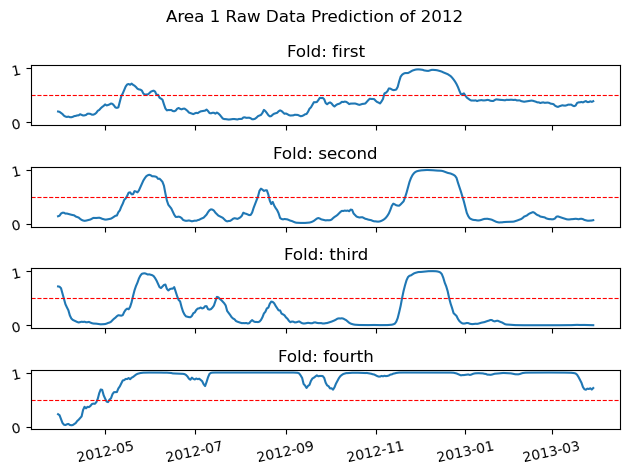

In [7]:
fig, ax = plt.subplots(4, sharey='all', sharex='all')

for index, fold in enumerate(file_names):
    data_frame = pd.DataFrame({'date' : fold_stats[index][0], 'probs' : fold_stats[index][1], 
                               'pred' : fold_stats[index][2], 'actual' : fold_stats[index][3]})
    # data_frame
    data_frame['pred'] = data_frame['pred'] + 0.03
    data_frame = data_frame.sort_values(by='date')
    data_frame['date'] = pd.to_datetime(data_frame['date']) + pd.Timedelta(days=29)

    r_n = range(58, 423)
    # r_n = range(0, data_frame.shape[0])

    ax[index].plot(data_frame['date'].iloc[r_n], data_frame['probs'].iloc[r_n])
    # ax[index].plot(data_frame['date'].iloc[r_n], data_frame['actual'].iloc[r_n])
    ax[index].set_title("Fold: " + fold)
    ax[index].axhline(0.5, color='red', linewidth=0.8, ls="--")
    ax[index].tick_params(labelrotation=12)
fig.suptitle("Area 1 Raw Data Prediction of 2012")
# ax[1].tick_params(labelrotation=12)
fig.tight_layout()
# fig.
# fig.savefig("area1crossvalidation-after2012.pdf")

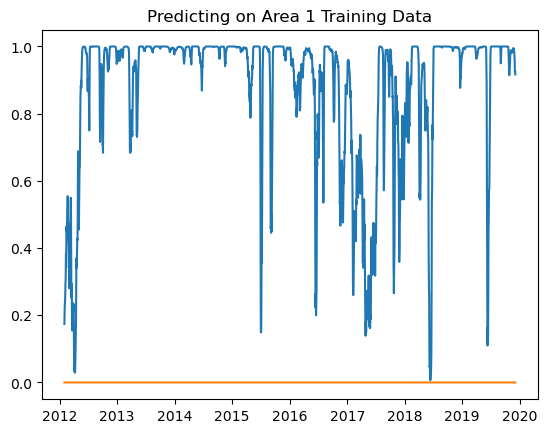

In [8]:
data_frame = pd.DataFrame({'date' : dates, 'probs' : probabilities, 'pred' : predicted_labels, 'actual' : actual_labels})
data_frame['pred'] = data_frame['pred'] + 0.03
data_frame = data_frame.sort_values(by='date')
data_frame['date'] = pd.to_datetime(data_frame['date']) + pd.Timedelta(days=29)

r_n = range(0, data_frame.shape[0])

plt.plot(data_frame['date'].iloc[r_n], data_frame['probs'].iloc[r_n])
plt.plot(data_frame['date'].iloc[r_n], data_frame['actual'].iloc[r_n])
# plt.plot(data_frame['date'].iloc[r_n], data_frame['pred'].iloc[r_n])
plt.title("Predicting on Area 1 Training Data")
# plt.legend(['Probability', 'Predicted'])
plt.savefig("2012-area-1.pdf")

# data_frame.to_csv("./confusion_matrix_data/area3/A2model_A3data.csv")

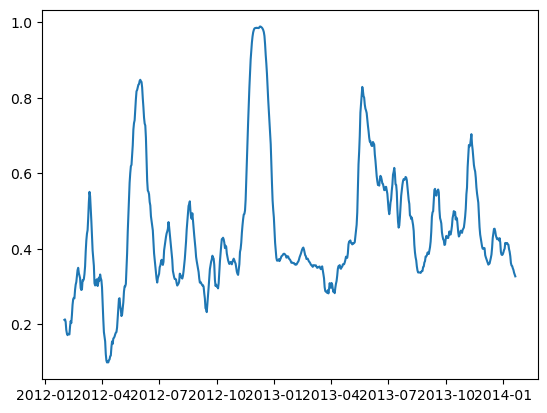

In [9]:
final = (np.array(fold_stats[0][1]) + np.array(fold_stats[1][1]) + np.array(fold_stats[2][1]) + np.array(fold_stats[3][1]))/4
final_df = pd.DataFrame({'date' : dates, 'probs' : final})
final_df = final_df.sort_values(by='date')
final_df['date'] = pd.to_datetime(final_df['date']) + pd.Timedelta(days=29)

r_n = range(0, 720)

plt.plot(final_df['date'].iloc[r_n], final_df['probs'].iloc[r_n])
final_df.to_csv("final_prediction_df.csv")

# LRP for after 2012

In [10]:
date_in_q = pd.to_datetime('2012-12-12') - pd.Timedelta(days=29)


for index in range(len(dataset)):
    # print(index)
    if (pd.to_datetime(dataset[index][2]) == date_in_q):
        print("Found date")
        found_index = index
        break

picked_point = dataset[found_index]


path = "/Users/haxby/Desktop/Earthquakes/gnss-sse-detection-main/cross_validation_results/area1/"
file_names = ['first', 'second', 'third', 'fourth']

fold_stats = []

print("Start Date:", date_in_q)
x = torch.tensor(picked_point[0]).to(device)
x = torch.unsqueeze(x, 0)

lrp_results = []

for count, fold in enumerate(file_names):

    # load the saved model in
    model_path = path + fold + "/saved_model.pth"
    num_chans = 30
    model = eegnet.EEGNet(Chans = num_chans, Samples = 128, nb_classes=1, kernLength=5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    p = model(x)
    print(fold, p.item())
    lrp_model = LRPModel(model)
    rel = lrp_model.forward(x)
    rel = rel.numpy()
    lrp_results.append(rel)


Found date
Start Date: 2012-11-13 00:00:00
first 0.9625639319419861
second 0.9823948740959167
third 0.9960862398147583
fourth 1.0


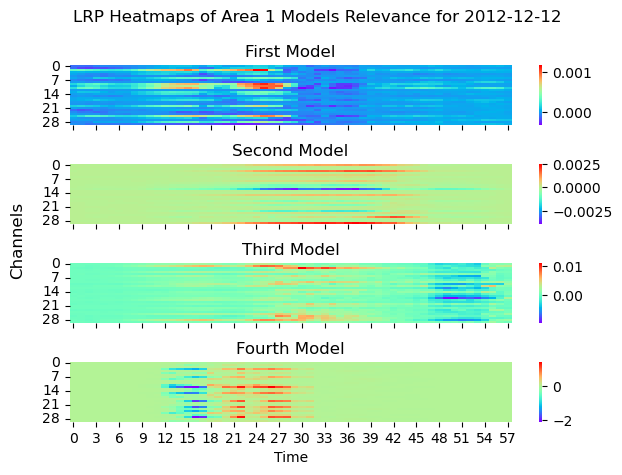

In [18]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex='all', sharey='all')

g1 = sns.heatmap(lrp_results[0], cmap='rainbow', ax=ax1, cbar=True)
g1.set_title("First Model")
g1.set_yticklabels([0, 7, 14, 21, 28], rotation=0)
# ax1.axvline(39, linewidth=0.7, color='black', ls="--")
# ax1.axvline(46, linewidth=0.7, color='black', ls="--")
# ax1.axhline(12, linewidth=0.7, color='black', ls="--")
# ax1.axhline(20, linewidth=0.7, color='black', ls="--")
# ax1.axhline(23, linewidth=0.7, color='black', ls="--")
# ax1.axhline(26, linewidth=0.7, color='black', ls="--")

g2 = sns.heatmap(lrp_results[1], cmap='rainbow', ax=ax2, cbar=True)
g2.set_yticklabels([0, 7, 14, 21, 28], rotation=0)
g2.set_title("Second Model")
# g2.set_yticklabels([0, 4, 8, 12, 16, 20, 24, 28], rotation=0)
# ax2.axvline(32, linewidth=0.7, color='black', ls="--")
# ax2.axvline(39, linewidth=0.7, color='black', ls="--")

g3 = sns.heatmap(lrp_results[2], cmap='rainbow', ax=ax3, cbar=True)
g3.set_yticklabels([0, 7, 14, 21, 28], rotation=0)
g3.set_title("Third Model")

g4 = sns.heatmap(lrp_results[3], cmap='rainbow', ax=ax4, cbar=True)
g4.set_title("Fourth Model")
g4.set_yticklabels([0, 7, 14, 21, 28], rotation=0)
fig.suptitle("LRP Heatmaps of Area 1 Models Relevance for 2012-12-12")
fig.tight_layout()
fig.supylabel("Channels")
g4.set_xlabel("Time")
fig.tight_layout()


fig.savefig("lrpon2012.pdf")